Regulatory graph visualization with GINsim

GINsim models in GINML format contains layout information for displaying the regulatory graph of a Boolean or multi-valued network. The regulatory graph shows the activation and inhibition relations between the nodes of the network.

In this notebook, we show how to use the ginsim Python module to visualize a network model, with optionally a state.



In [1]:
import ginsim #To visulaize the model
import biolqm #To change node parameters and values
import maboss #To run simulations on the models 
import boolsim # To find attractors 
import numpy as np 
import pandas as pd 
from colomoto_jupyter import tabulate 
from itertools import combinations  
import matplotlib.pyplot as plt 

FIXED POINT ANALYSIS

In [3]:
# import the model to biolqm for updating the model using asynchronous updating
lqm = biolqm.load("HSC_MSC_MK.zginml")

# import the model with ginsim to visualize the model 
lrg = ginsim.load("HSC_MSC_MK.zginml")
ginsim.show(lrg)

In [4]:
#wt_sim refers to the Wild Type state where there is no mutation in any of the nodes
wt_sim = biolqm.to_maboss(lqm) #Converts the model to a MaBoss object required to run the simulation 

In [5]:
# [0,1] refers to 0% probability of the node being OFF and 100% probability of it being ON 
# [1,0] refers to 100% probability of the node being OFF and 0% probability of it being ON

maboss.set_nodes_istate(wt_sim, ["TPO"], [0, 1]) 
maboss.set_nodes_istate(wt_sim, ["lTLR"], [0, 1])


In [6]:
#HSC_proliferation_b1 refers to active state, 
#HSC_proliferation_b2 refers to Hyperactive state 
wt_sim.network.set_output(('HSC_proliferation_b1','HSC_proliferation_b2','HSC_migration','PMF')) #Sets the nodes that is displayed in the results graph

In [7]:
wt_sim.update_parameters(discrete_time=0, use_physrandgen=0,
        seed_pseudorandom=100, sample_count=50000,
        max_time=30, time_tick=0.1, thread_count=4,
        statdist_traj_count=100, statdist_cluster_threshold=0.9)  # Sets simulation parameters

In [27]:
#Simulation of the wild-type model
%time wt_results = wt_sim.run()

CPU times: user 6.8 ms, sys: 2.96 ms, total: 9.77 ms
Wall time: 9.61 s


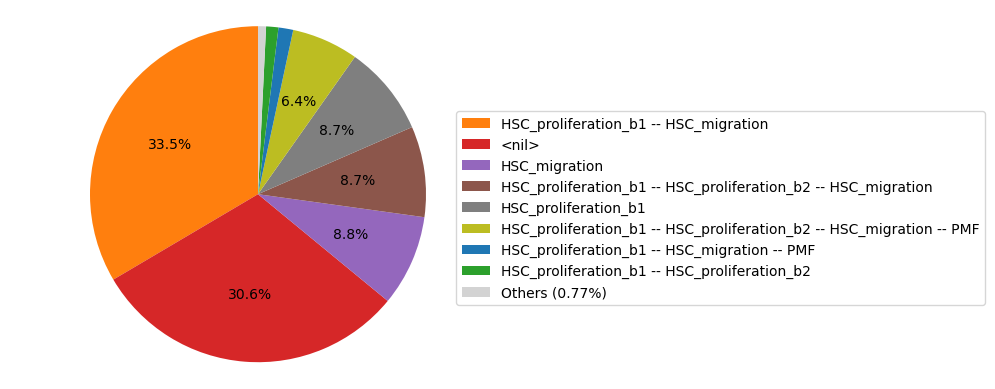

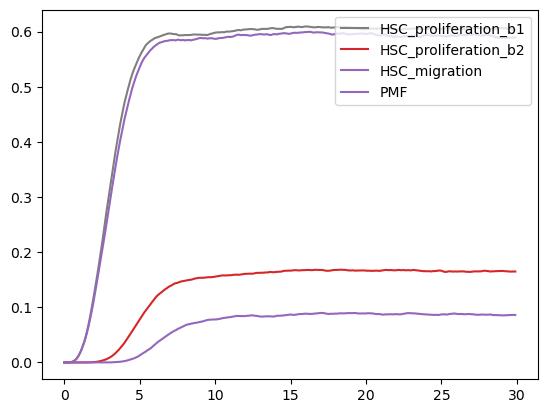

In [28]:
#Plotting the Results 

#The second graph shows 10% probability of PMF even when there is no mutation , this coincides with findings.
wt_results.plot_piechart()
wt_results.plot_node_trajectory(until=35)

In [10]:
#Simulation of double mutant JAK_H/JAK_MK(according to the paper)
mut_sim = wt_sim.copy()#creates a copy of the maboss object for mutation
mut_sim.mutate("JAK_H_b2", "ON") #b2 refers to the hyperactive node (this is the JAK in the Hematopoeitic Stem Cell)
mut_sim.mutate("JAK_MK_b2", "ON")#b2 refers to the hyperactive node (this is the JAK in the Megakaryocyte)

In [11]:
maboss.set_nodes_istate(mut_sim, ["TPO"], [0, 1])
maboss.set_nodes_istate(mut_sim, ["lTLR"], [0, 1])

In [12]:
mut_sim.network.set_output(('HSC_proliferation_b1', 'HSC_proliferation_b2','HSC_migration','PMF','PF4_MK'))

In [13]:
%time mut_results = mut_sim.run()

CPU times: user 6.61 ms, sys: 1.27 ms, total: 7.88 ms
Wall time: 3.91 s


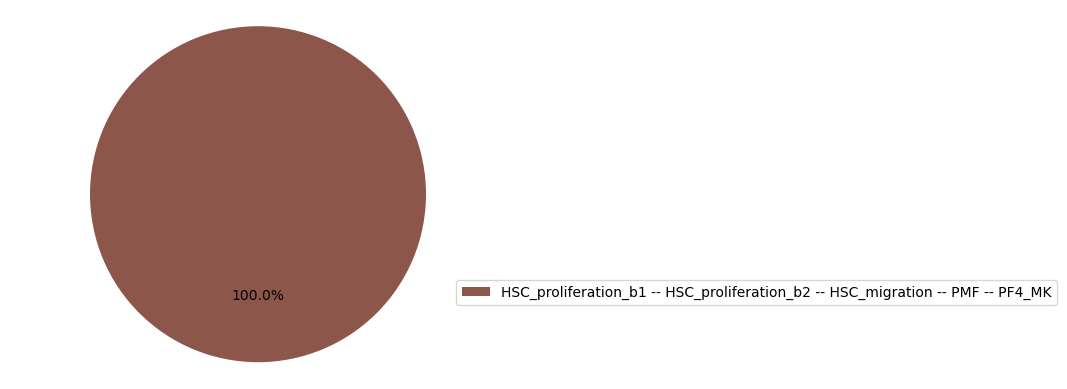

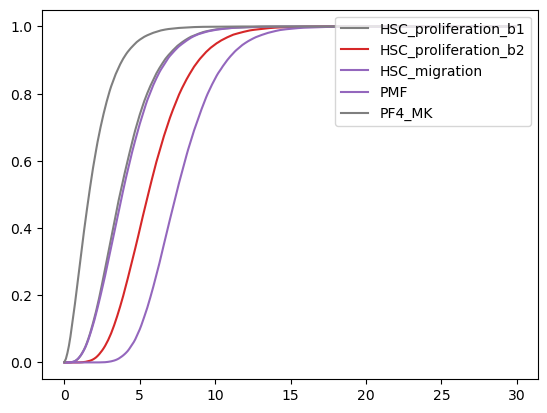

In [14]:
#These graphs show that there is a 100% probability of PMF occuring where JAK is hyperactive
mut_results.plot_piechart()
mut_results.plot_node_trajectory(until=35)

In [16]:
#Simultation where PF4_MK is OFF (CXCL4 is OFF)
mut_sim2 = wt_sim.copy()
mut_sim2.mutate("JAK_H_b2", "ON")
mut_sim2.mutate("JAK_MK_b2", "ON")
mut_sim2.mutate("PF4_MK", "OFF")

In [17]:
maboss.set_nodes_istate(mut_sim2, ["TPO"], [0, 1])
maboss.set_nodes_istate(mut_sim2, ["lTLR"], [0, 1])

In [18]:
mut_sim2.network.set_output(('PMF','PF4_MK', 'HSC_proliferation_b1', 'HSC_proliferation_b2', 'HSC_migration' ))

In [19]:
%time mut_results2 = mut_sim2.run()

CPU times: user 634 μs, sys: 6.49 ms, total: 7.12 ms
Wall time: 3.98 s


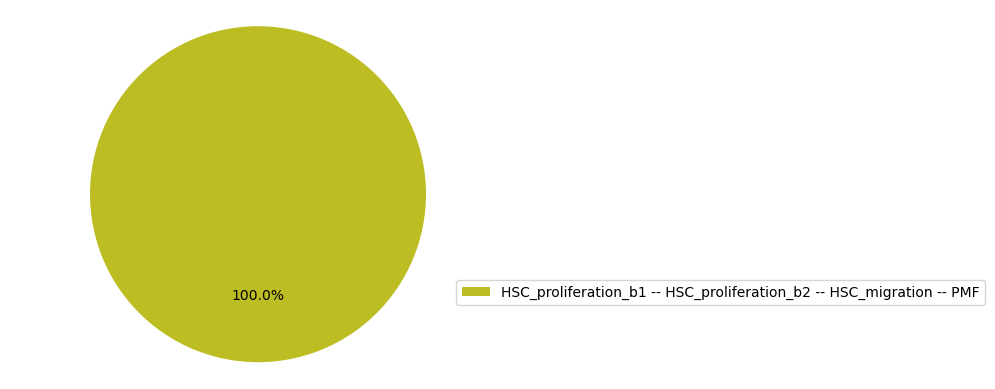

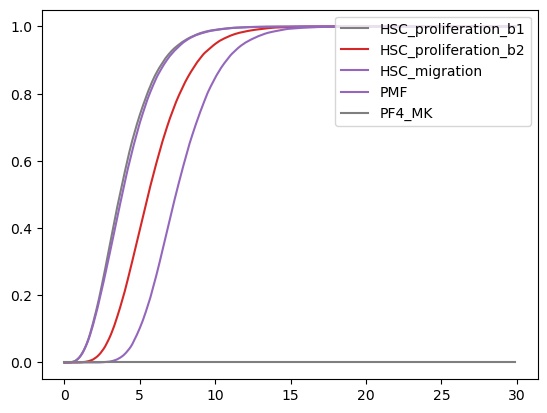

In [20]:
#The graphs show that there is still 100% probability of PMF happening even when CXCL4 is OFF
mut_results2.plot_piechart()
mut_results2.plot_node_trajectory(until=35)

In [21]:
#Simultation where PF4_MK is OFF (CXCL4 is OFF) and ltlr is OFF
mut_sim3 = wt_sim.copy()
mut_sim3.mutate("JAK_H_b2", "ON")
mut_sim3.mutate("JAK_MK_b2", "ON")
mut_sim3.mutate("PF4_MK", "OFF")

In [22]:
maboss.set_nodes_istate(mut_sim3, ["TPO"], [0, 1])
maboss.set_nodes_istate(mut_sim3, ["lTLR"], [1, 0])#lTLR is OFF

In [23]:
mut_sim3.network.set_output(('PMF','PF4_MK', 'HSC_proliferation_b1', 'HSC_proliferation_b2', 'HSC_migration' ))

In [24]:
%time mut_results3 = mut_sim3.run()

CPU times: user 4.18 ms, sys: 3.15 ms, total: 7.33 ms
Wall time: 3.62 s


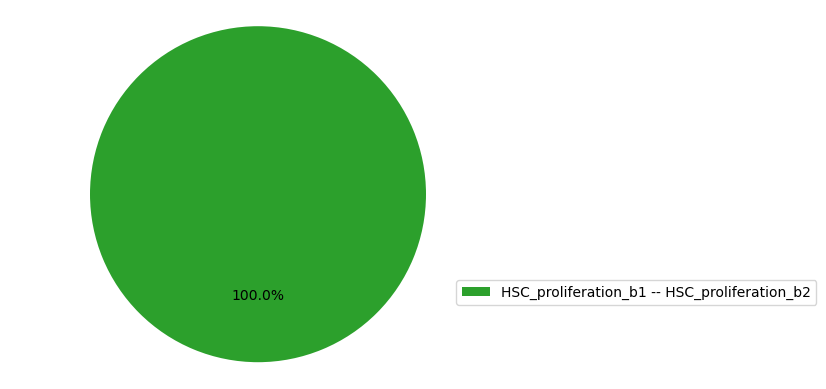

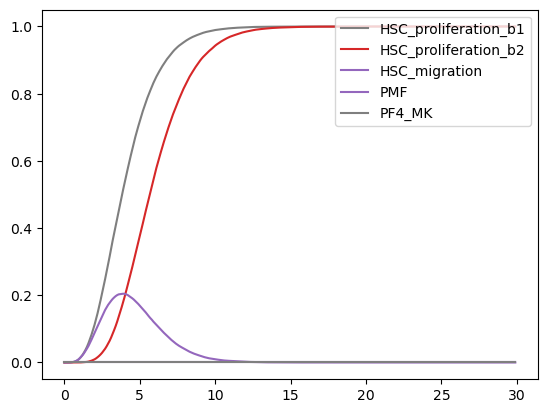

In [25]:
#The graphs show a spike in PMF but then reduces back to 0%
mut_results3.plot_piechart()
mut_results3.plot_node_trajectory(until=35)

In [31]:
#Creating perturbations for boolsim to find attractors 
perturbations1 = "lTLR%1 , TPO%1 , JAK_H%2 , JAK_MK%2 , PF4_MK%0" #%0 is OFF, %1 is ON, %2 is hyperactive 
perturbed_lqm1 = biolqm.perturbation(lqm, perturbations1)

In [ ]:
attractors1=boolsim.attractors(perturbed_lqm1,update_mode="asynchronous")
attractors1 #These results were complied into a Table 1 in the poster (for PMF state)
#Shows the stable or cyclic attractor, in this case it is a stable attractor because there is only one state where all nodes have a fixed value and do not oscillate. 
#In Fixed (Stable) attractors ,once a final state is reached it does not deviate from that state, cyclic attractors osciallate between multiple states.
#Here the final stable state is PMF being ON with the following nodes

[{'Bcatenin_H': 1,
  'Bcatenin_M': 1,
  'CXCL12_M': 0,
  'CXCR4_H': 0,
  'ERK_H': 1,
  'ERK_M': 1,
  'FoxO3a_H': 0,
  'FoxO3a_M': 0,
  'GCSF': 1,
  'GSK3B_H': 0,
  'GSK3B_M': 0,
  'HSC_migration': 1,
  'HSC_proliferation_b1': 1,
  'HSC_proliferation_b2': 1,
  'IL1': 1,
  'IL6': 1,
  'JAK_H_b1': 1,
  'JAK_H_b2': 1,
  'JAK_MK_b1': 1,
  'JAK_MK_b2': 1,
  'lTLR': 1,
  'NfkB_H_b1': 1,
  'NfkB_H_b2': 1,
  'NfkB_M': 1,
  'NfkB_MK_b1': 1,
  'NfkB_MK_b2': 1,
  'PF4_MK': 0,
  'PI3KAkt_H_b1': 1,
  'PI3KAkt_H_b2': 1,
  'PI3KAkt_M': 1,
  'PI3KAkt_MK_b1': 1,
  'PI3KAkt_MK_b2': 1,
  'PMF': 1,
  'ROS_H': 1,
  'ROS_M': 1,
  'SOCS_H': 1,
  'SOCS_MK': 1,
  'STAT_H_b1': 1,
  'STAT_H_b2': 1,
  'STAT_MK_b1': 1,
  'STAT_MK_b2': 1,
  'TGFb_MK': 1,
  'TLRs4_H': 1,
  'TLRs4_M': 1,
  'TLRs4_MK': 1,
  'TPO': 1,
  'VCAM1_M': 1,
  'VLA4_H': 0,
  'VLA4_MK': 1}]

In [33]:
#To visualise Cyclic attractors
perturbations0 = "lTLR%1 , TPO%1" #The wild type condition is a cyclic attractor 
perturbed_lqm0 = biolqm.perturbation(lqm, perturbations0)

In [34]:
attractors0=boolsim.attractors(perturbed_lqm0,update_mode="asynchronous")#This takes a while because it calculates all oscillating states for all the nodes.
attractors0 
#* refers to oscillatiing nodes
#PMF can oscillate in severity depending on the state of other nodes.

[[{'Bcatenin_H': '*',
   'Bcatenin_M': 1,
   'CXCL12_M': '*',
   'CXCR4_H': 0,
   'ERK_H': '*',
   'ERK_M': 1,
   'FoxO3a_H': '*',
   'FoxO3a_M': 0,
   'GCSF': 1,
   'GSK3B_H': '*',
   'GSK3B_M': 0,
   'HSC_migration': '*',
   'HSC_proliferation_b1': 0,
   'HSC_proliferation_b2': 0,
   'IL1': 1,
   'IL6': 1,
   'JAK_H_b1': 0,
   'JAK_H_b2': 0,
   'JAK_MK_b1': 0,
   'JAK_MK_b2': 0,
   'lTLR': 1,
   'NfkB_H_b1': 1,
   'NfkB_H_b2': '*',
   'NfkB_M': 1,
   'NfkB_MK_b1': 1,
   'NfkB_MK_b2': 1,
   'PF4_MK': 1,
   'PI3KAkt_H_b1': 0,
   'PI3KAkt_H_b2': 0,
   'PI3KAkt_M': 1,
   'PI3KAkt_MK_b1': 1,
   'PI3KAkt_MK_b2': '*',
   'PMF': '*',
   'ROS_H': 1,
   'ROS_M': 1,
   'SOCS_H': '*',
   'SOCS_MK': 0,
   'STAT_H_b1': 0,
   'STAT_H_b2': 0,
   'STAT_MK_b1': 0,
   'STAT_MK_b2': 0,
   'TGFb_MK': '*',
   'TLRs4_H': 1,
   'TLRs4_M': 1,
   'TLRs4_MK': 1,
   'TPO': 1,
   'VCAM1_M': 1,
   'VLA4_H': 0,
   'VLA4_MK': 1},
  {'Bcatenin_H': '*',
   'Bcatenin_M': 1,
   'CXCL12_M': '*',
   'CXCR4_H': 0,
   'ERK

In [35]:
perturbations3 = "lTLR%0 , TPO%1 , JAK_H%2 , JAK_MK%2 , PF4_MK%0" #ltlr is OFF
perturbed_lqm3 = biolqm.perturbation(lqm, perturbations3)

In [36]:
attractors3=boolsim.attractors(perturbed_lqm3,update_mode="asynchronous")#This results in a cyclic attractor where PMF is 0
attractors3 
#These results were complied into a Table 1 in the poster (for No PMF state)

[{'Bcatenin_H': 1,
  'Bcatenin_M': 1,
  'CXCL12_M': 1,
  'CXCR4_H': 1,
  'ERK_H': 1,
  'ERK_M': 1,
  'FoxO3a_H': 0,
  'FoxO3a_M': 0,
  'GCSF': 0,
  'GSK3B_H': 0,
  'GSK3B_M': 0,
  'HSC_migration': 0,
  'HSC_proliferation_b1': 1,
  'HSC_proliferation_b2': 1,
  'IL1': 1,
  'IL6': 1,
  'JAK_H_b1': 1,
  'JAK_H_b2': 1,
  'JAK_MK_b1': 1,
  'JAK_MK_b2': 1,
  'lTLR': 0,
  'NfkB_H_b1': 1,
  'NfkB_H_b2': 1,
  'NfkB_M': 1,
  'NfkB_MK_b1': 1,
  'NfkB_MK_b2': 0,
  'PF4_MK': 0,
  'PI3KAkt_H_b1': 1,
  'PI3KAkt_H_b2': 1,
  'PI3KAkt_M': 1,
  'PI3KAkt_MK_b1': 1,
  'PI3KAkt_MK_b2': 1,
  'PMF': 0,
  'ROS_H': 1,
  'ROS_M': 1,
  'SOCS_H': 1,
  'SOCS_MK': 1,
  'STAT_H_b1': 1,
  'STAT_H_b2': 1,
  'STAT_MK_b1': 1,
  'STAT_MK_b2': 1,
  'TGFb_MK': 0,
  'TLRs4_H': 0,
  'TLRs4_M': 0,
  'TLRs4_MK': 0,
  'TPO': 1,
  'VCAM1_M': 1,
  'VLA4_H': 1,
  'VLA4_MK': 1}]

In [41]:
#To visulaize the stable attractors using Ginsim fixed points
lqm = biolqm.load("HSC_MSC_MK.zginml")
pert = biolqm.perturbation(lqm, "lTLR%0 , TPO%1 , JAK_H%2 , JAK_MK%2 , PF4_MK%0")

In [42]:
fps = biolqm.fixpoints(pert)
pd.DataFrame(fps)
print(len(fps), "fixpoints") #1 fixpoint like shown by Boolsim

1 fixpoints


In [43]:
ginsim.show(lrg, fps[0])#Shows the active(blue) and inactive nodes (white) This was shown in the poster Fig.5 

In [44]:
#To visulaize the stable attractors using Ginsim fixed points
lqm = biolqm.load("HSC_MSC_MK.zginml")
pert = biolqm.perturbation(lqm, "lTLR%1 , TPO%1 , JAK_H%2 , JAK_MK%2 , PF4_MK%0")#ltlr is ON

In [45]:
fps = biolqm.fixpoints(pert)
pd.DataFrame(fps)
print(len(fps), "fixpoints") #1 fixpoint like shown by Boolsim

1 fixpoints


In [46]:
ginsim.show(lrg, fps[0])#Shows the active(blue) and inactive nodes (white) This was shown in the poster Fig.6